# Version  
** 1.2 **  
1.2 Support for EXPLORE_MODE, allowing for succinct or full logging of data  
1.1 Added plot support  
1.0 1st release after review.  




This is just an increasing number. If you make a change increase the number - major.minor  


Develop a program in Python using the Keras Neural Network to implement a classifier fot the NMIST handwritten digits database. It is recommended to use a convolution neural network.

# Project Team  
Qinyuan                 20137095  
Eamon Moloney           8457077  
Ibrahim Saana Aminu     25381993  
Des Powell              9513833  
Terence Coffey          15223124  

2024-11-29 14:01:10 Step 1 - Strong Classifier Test Accuracy: 96.58%
2024-11-29 14:01:10 Step 2 - Accuracy: Train 98.50%, Test 96.58%
2024-11-29 14:01:10 Step 3 - Generate Decision Boundry Data
2024-11-29 14:03:32 Step 4 - Generate Contour Data
2024-11-29 14:05:50 Step 5 - Plots


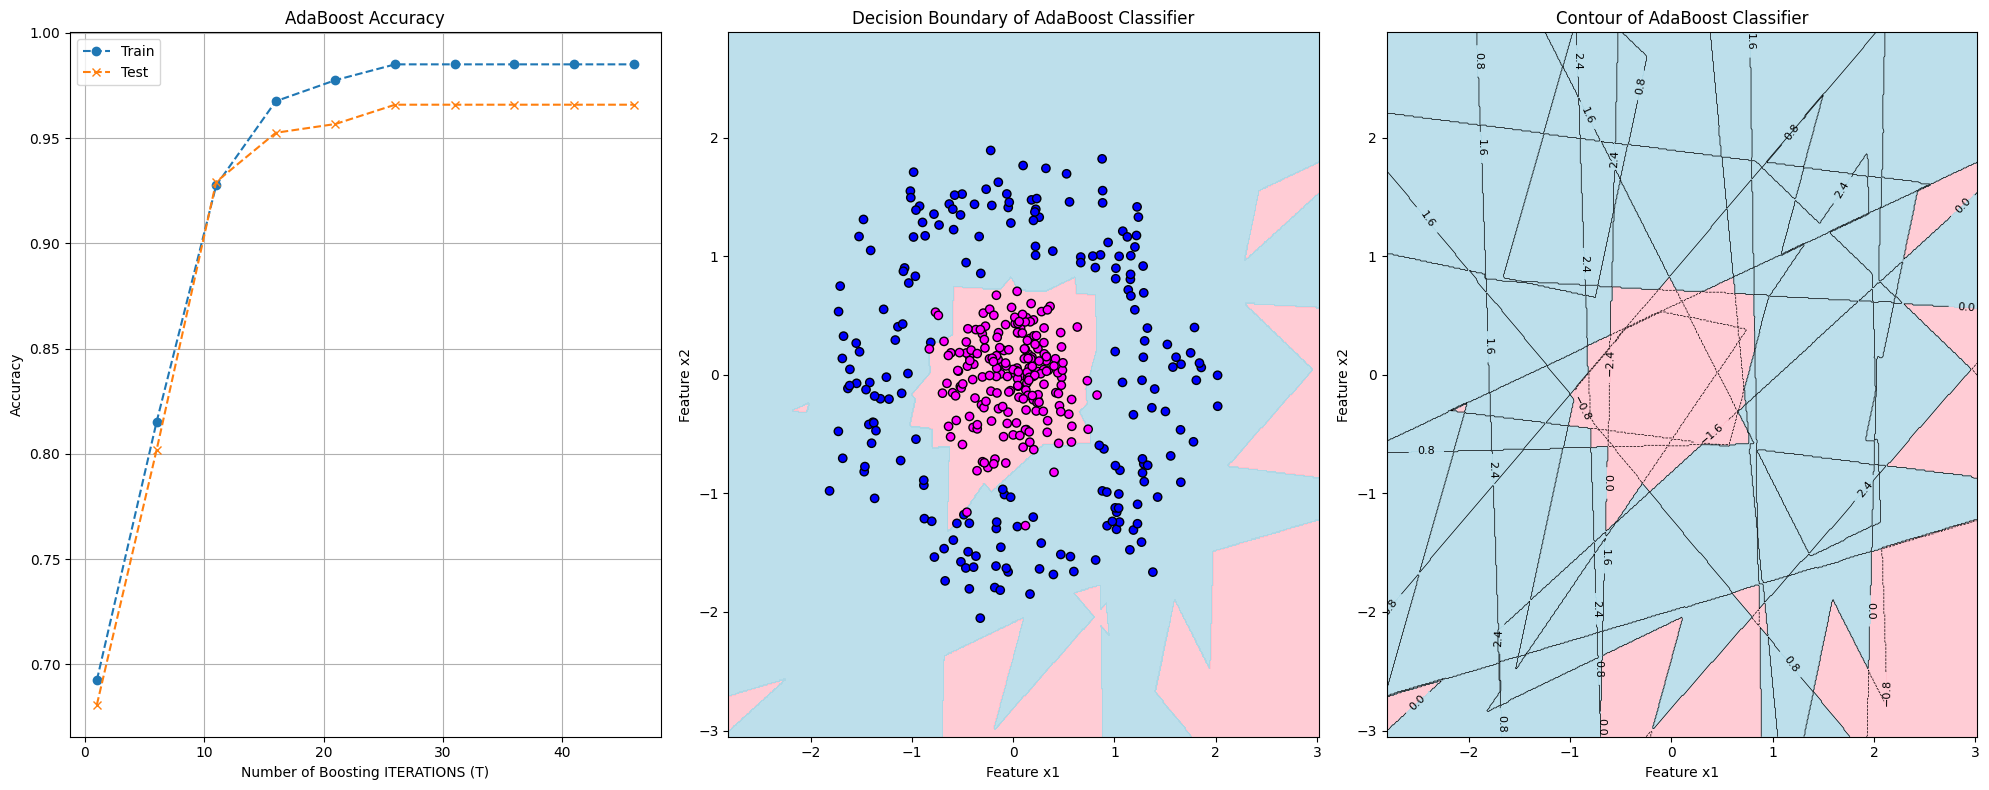

In [1]:
# --------------------------------------------------------------------------------------------------
# Main program
#
# 27/11/24
# Ver 1.0  Project submission Nov 2024
# --------------------------------------------------------------------------------------------------

# --------------------------------------------------------------------------------------------------
# library imports
# --------------------------------------------------------------------------------------------------
import os
import numpy as np
import pandas as pd
from common.algorithm import AdaBoost
import common.plot_library as cpl
from implementations.sklearn_weak_classifier import SklearnWeakClassifier
from implementations.custom_weak_classifier import CustomWeakClassifier
from sklearn.metrics import accuracy_score
from datetime import datetime


# --------------------------------------------------------------------------------------------------
# constants
# --------------------------------------------------------------------------------------------------
ITERATIONS = 50

# --------------------------------------------------------------------------------------------------
# Load data into numpy arrays
# --------------------------------------------------------------------------------------------------
train_file = './adaboost-train-24.txt'
test_file = './adaboost-test-24.txt'
column_names = ['X1', 'X2', 'Y']
df_train = pd.read_csv(train_file, sep=r'\s+', header=None, names=column_names)
df_test = pd.read_csv(test_file, sep=r'\s+', header=None, names=column_names)
X_train = df_train[['X1', 'X2']].to_numpy()
Y_train = df_train['Y'].to_numpy()
X_test = df_test[['X1', 'X2']].to_numpy()
Y_test = df_test['Y'].to_numpy()
#print(df_test.describe())

# -----------------------------------------------------------------------------------------------------
# Main 
# -----------------------------------------------------------------------------------------------------
def main():

    # 1 - TEST ACCURACY AFTER N ITERATIONS - Ntest = 26
    Ntest=26
    weak_classifier_ = CustomWeakClassifier() # simlply replace CustomWeakClassifier() with SklearnWeakClassifier() if using sklearn implementation
    adaboost_strong_classifier_ = AdaBoost(weak_classifier_strategy=weak_classifier_)    
    classifiers_, alphas_ = adaboost_strong_classifier_.train(X_train, Y_train, Ntest)
    y_test_pred, y_test_pred_value = adaboost_strong_classifier_.predict(X_test, classifiers_[:Ntest], alphas_[:Ntest])
    accuracy = accuracy_score(Y_test, y_test_pred)
    print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} Step 1 - Strong Classifier Test Accuracy: {accuracy:.2%}")
    
    # 2 - MEASURE TRAIN & TEST ACCURACY OVER Ntest plus ITERATIONS 
    cpl.train_acc, cpl.test_acc = measure_accuracy_of_predictions(adaboost_strong_classifier_, classifiers_, alphas_, ITERATIONS)
    print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} Step 2 - Accuracy: Train {cpl.train_acc[-1]:.2%}, Test {cpl.test_acc[-1]:.2%}")
    
    # 3 - GENERATE DECISION BOUNDRY DATA - using training data
    print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} Step 3 - Generate Decision Boundry Data")
    cpl.X, cpl.y, cpl.Z, cpl.xx, cpl.yy = generate_decision_boundry_data(X_train, Y_train, adaboost_strong_classifier_, classifiers_, alphas_, Ntest)
    
    # 4 - GENERATE CONTOUR DATA - using test data
    print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} Step 4 - Generate Contour Data")
    cpl.Z_values, cpl.xx, cpl.yy = generate_contour_data(X_train, adaboost_strong_classifier_, classifiers_, alphas_, Ntest)
       
    # 5 - PLOTS 
    print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} Step 5 - Plots")
    cpl.generate_plots()
 


# -----------------------------------------------------------------------------------------------------
# measure_accuracy_of_predictions 
# -----------------------------------------------------------------------------------------------------
def measure_accuracy_of_predictions(adaboost_classifier, classifiers, alphas, iterations):
    train_acc = []
    test_acc = []
    
    for t in range(1, iterations + 1):
        y_train_pred, not_used = adaboost_classifier.predict(X_train, classifiers[:t], alphas[:t])
        y_test_pred, not_used = adaboost_classifier.predict(X_test, classifiers[:t], alphas[:t])
        # train_acc, test_acc store the accuracy data for later plotting
        train_acc.append(accuracy_score(Y_train, y_train_pred))
        test_acc.append(accuracy_score(Y_test, y_test_pred))
    return train_acc, test_acc


# -----------------------------------------------------------------------------------------------------
# generate_decision_boundry_data 
# -----------------------------------------------------------------------------------------------------
def generate_decision_boundry_data(X, y, adaboost_classifier, classifiers, alphas, N_value):
    resolution=0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # create a mesh grid covering the feature space
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))   
    # flatten the grid and predict
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z, not_used = zip(*[
            adaboost_classifier.predict(point.reshape(1, -1), classifiers[:N_value], alphas[:N_value])
            for point in grid_points
        ])
    # Z contains the predicted class for train data
    Z = np.array(Z).reshape(xx.shape)  

    return X, y, Z, xx, yy
    
# ---------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
# generate_contour_data 
# -----------------------------------------------------------------------------------------------------
def generate_contour_data(X, adaboost_classifier, classifiers, alphas, N_value):
    # generate grid using mgrid
    resolution = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))  

    # flatten the grid and predict
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    not_used, Z_values = zip(*[
        adaboost_classifier.predict(point.reshape(1, -1), classifiers[:N_value], alphas[:N_value])
        for point in grid_points
    ])
    # Z_values contains the predicted values for train data
    Z_values = np.array(Z_values).reshape(xx.shape)
    
    return Z_values, xx, yy

# ---------------------------------------------------------------------------------------

# make main run first
if __name__ == "__main__":
    main()
    


sjdalkajdksajdlksajlkdksajd
aslkjdlkasjdlkasd
ksajdlksajdkla
sakjdlkajdlsak


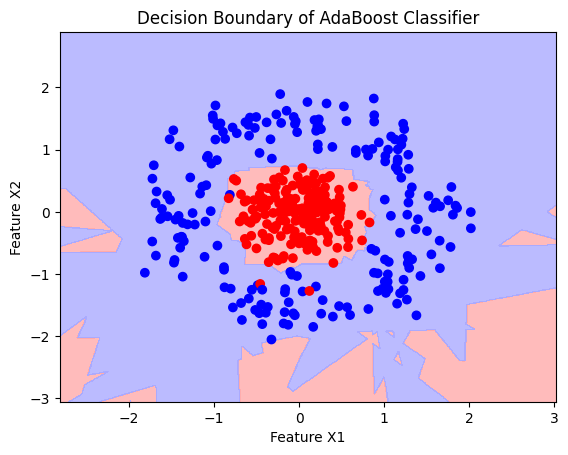

Test Accuracy: 96.67%


In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# --------------------------------------------------------------------------------------------------
# Constants
# --------------------------------------------------------------------------------------------------
ITERATIONS = 50
ALPHA_CLIP_VALUE = 25

# --------------------------------------------------------------------------------------------------
# Custom Weak Classifier
# --------------------------------------------------------------------------------------------------
class CustomWeakClassifier:
    def __init__(self):
        self.threshold = None
        self.n = None
        self.classes_ = None
        self.error = None

    def fit(self, X, y, sample_weight=None):
        self.classes_ = np.unique(y)
        n_samples, n_features = X.shape
        min_error = float("inf")

        # Project features onto orientation vector
        _, projections, n = self.get_projected_features(X, y, sample_weight)
        self.n = n
        thresholds = np.unique(projections)
        thresholds = np.sort((thresholds[:-1] + thresholds[1:]) / 2)  # Midpoints

        for threshold in thresholds:
            pred = np.ones(n_samples)
            pred[projections < threshold] = -1

            error = np.sum(sample_weight * (pred != y))
            if error < min_error:
                min_error = error
                self.threshold = threshold

        self.error = min_error
        return self

    def predict(self, X):
        if self.threshold is None or self.n is None:
            raise ValueError("Classifier is not fitted yet.")
        projections = np.dot(X, self.n)  # Projection onto orientation vector
        pred = np.ones(X.shape[0])
        pred[projections < self.threshold] = -1
        return pred

    @staticmethod
    def create_weak_classifier(X, y, sample_weights):
        clf = CustomWeakClassifier()
        clf.fit(X, y, sample_weight=sample_weights)
        return clf

    @staticmethod
    def get_projected_features(X, y, weights):
        pos_idx = y == 1
        neg_idx = y == -1

        # Weighted means for all feature dimensions
        u_pos = np.sum(weights[pos_idx, None] * X[pos_idx], axis=0) / np.sum(weights[pos_idx])
        u_neg = np.sum(weights[neg_idx, None] * X[neg_idx], axis=0) / np.sum(weights[neg_idx])

        # Orientation vector
        r = u_pos - u_neg
        r_magnitude = np.linalg.norm(r)
        n = r / r_magnitude if r_magnitude != 0 else np.zeros_like(r)

        # Project features onto orientation vector
        projections = np.dot(X, n)
        return X, projections, n

# --------------------------------------------------------------------------------------------------
# AdaBoost Algorithm
# --------------------------------------------------------------------------------------------------
class AdaBoost:
    def __init__(self, weak_classifier_strategy):
        self.weak_classifier_strategy = weak_classifier_strategy

    def train(self, X, y, T):
        classifiers = []
        alphas = []
        n_samples = X.shape[0]
        sample_weights = np.ones(n_samples) / n_samples
        epsilon = 1e-10  # Small constant to prevent division by zero

        for t in range(T):
            clf = self.weak_classifier_strategy.create_weak_classifier(X, y, sample_weights)
            classifiers.append(clf)

            # Predict and calculate error
            y_pred = clf.predict(X)
            incorrect = (y_pred != y).astype(float)
            error = np.sum(sample_weights * incorrect) / np.sum(sample_weights)

            # Calculate alpha
            if error == 0:
                alpha = ALPHA_CLIP_VALUE
            elif error == 1:
                alpha = -ALPHA_CLIP_VALUE
            else:
                alpha = 0.5 * np.log((1 - error) / error)
            alphas.append(alpha)

            # Update sample weights
            sample_weights *= np.exp(-alpha * y * y_pred)
            sample_weights /= np.sum(sample_weights)

        return classifiers, alphas

    def predict(self, X, classifiers, alphas):
        adaboost_classifier_prediction = np.array([
            alpha * clf.predict(X) for clf, alpha in zip(classifiers, alphas)
        ])
        predicted_value = np.sum(adaboost_classifier_prediction, axis=0)
        return np.sign(predicted_value), predicted_value

# --------------------------------------------------------------------------------------------------
# Plot Functions
# --------------------------------------------------------------------------------------------------
def plot_decision_boundary(X, y, adaboost, classifiers, alphas, Ntest):
    resolution = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z, _ = adaboost.predict(grid_points, classifiers[:Ntest], alphas[:Ntest])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=ListedColormap(["#FFAAAA", "#AAAAFF"]))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(["#FF0000", "#0000FF"]))
    plt.title("Decision Boundary of AdaBoost Classifier")
    plt.xlabel("Feature X1")
    plt.ylabel("Feature X2")
    plt.show()

# --------------------------------------------------------------------------------------------------
# Main Function
# --------------------------------------------------------------------------------------------------
def main():
    # Load data
    train_file = './adaboost-train-24.txt'
    test_file = './adaboost-test-24.txt'
    column_names = ['X1', 'X2', 'Y']
    df_train = pd.read_csv(train_file, sep=r'\s+', header=None, names=column_names)
    df_test = pd.read_csv(test_file, sep=r'\s+', header=None, names=column_names)
    X_train = df_train[['X1', 'X2']].to_numpy()
    Y_train = df_train['Y'].to_numpy()
    X_test = df_test[['X1', 'X2']].to_numpy()
    Y_test = df_test['Y'].to_numpy()

    # Initialize AdaBoost
    weak_classifier_ = CustomWeakClassifier()
    adaboost = AdaBoost(weak_classifier_strategy=weak_classifier_)
    classifiers, alphas = adaboost.train(X_train, Y_train, ITERATIONS)

    # Plot decision boundary
    plot_decision_boundary(X_train, Y_train, adaboost, classifiers, alphas, ITERATIONS)

    # Evaluate on test data
    y_test_pred, _ = adaboost.predict(X_test, classifiers, alphas)
    test_accuracy = accuracy_score(Y_test, y_test_pred)
    print(f"Test Accuracy: {test_accuracy:.2%}")

# --------------------------------------------------------------------------------------------------
# Run the main program
# --------------------------------------------------------------------------------------------------
if __name__ == "__main__":
    main()


Step 1 - Data loaded successfully!
Step 1 - Strong Classifier Test Accuracy: 96.67%
Step 2 - Accuracy: Train 99.50%, Test 96.67%
Step 3 - Generate Decision Boundary Data
Step 4 - Generate Contour Data
Step 5 - Plots


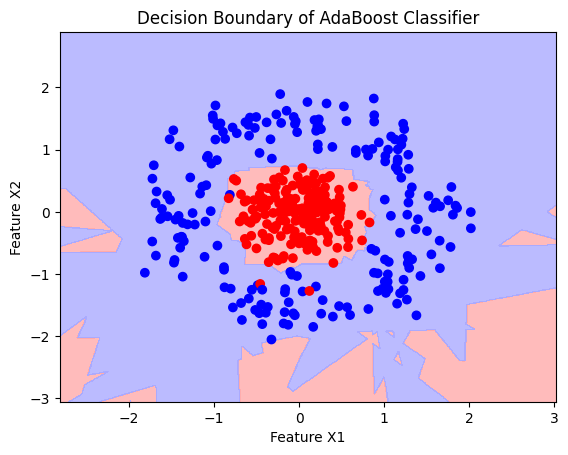

In [8]:

# --------------------------------------------------------------------------------------------------
# Plot Functions
# --------------------------------------------------------------------------------------------------
def plot_decision_boundary(X, y, adaboost, classifiers, alphas, Ntest):
    resolution = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z, _ = adaboost.predict(grid_points, classifiers[:Ntest], alphas[:Ntest])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=ListedColormap(["#FFAAAA", "#AAAAFF"]))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(["#FF0000", "#0000FF"]))
    plt.title("Decision Boundary of AdaBoost Classifier")
    plt.xlabel("Feature X1")
    plt.ylabel("Feature X2")
    plt.show()

# --------------------------------------------------------------------------------------------------
# Main Function
# --------------------------------------------------------------------------------------------------
def main():
    # Load data
    train_file = './adaboost-train-24.txt'
    test_file = './adaboost-test-24.txt'
    column_names = ['X1', 'X2', 'Y']
    df_train = pd.read_csv(train_file, sep=r'\s+', header=None, names=column_names)
    df_test = pd.read_csv(test_file, sep=r'\s+', header=None, names=column_names)
    X_train = df_train[['X1', 'X2']].to_numpy()
    Y_train = df_train['Y'].to_numpy()
    X_test = df_test[['X1', 'X2']].to_numpy()
    Y_test = df_test['Y'].to_numpy()

    print(f"Step 1 - Data loaded successfully!")

    # Initialize AdaBoost
    weak_classifier_ = CustomWeakClassifier()
    adaboost = AdaBoost(weak_classifier_strategy=weak_classifier_)

    # Train AdaBoost
    classifiers, alphas = adaboost.train(X_train, Y_train, ITERATIONS)

    # Test accuracy after N iterations
    Ntest = ITERATIONS
    y_test_pred, _ = adaboost.predict(X_test, classifiers[:Ntest], alphas[:Ntest])
    test_accuracy = accuracy_score(Y_test, y_test_pred)
    print(f"Step 1 - Strong Classifier Test Accuracy: {test_accuracy:.2%}")

    # Measure train and test accuracy for each iteration
    train_acc, test_acc = measure_accuracy_of_predictions(adaboost, classifiers, alphas, ITERATIONS)
    print(f"Step 2 - Accuracy: Train {train_acc[-1]:.2%}, Test {test_acc[-1]:.2%}")

    # Generate decision boundary data
    print(f"Step 3 - Generate Decision Boundary Data")
    X, y, Z, xx, yy = generate_decision_boundry_data(X_train, Y_train, adaboost, classifiers, alphas, ITERATIONS)

    # Generate contour data
    print(f"Step 4 - Generate Contour Data")
    Z_values, xx, yy = generate_contour_data(X_test, adaboost, classifiers, alphas, ITERATIONS)

    # Generate plots
    print(f"Step 5 - Plots")
    plot_decision_boundary(X_train, Y_train, adaboost, classifiers, alphas, ITERATIONS)


# --------------------------------------------------------------------------------------------------
# Run the main program
# --------------------------------------------------------------------------------------------------
if __name__ == "__main__":
    main()


In [2]:
pip install pandas

   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ------- -------------------------------- 2.1/11.6 MB 10.7 MB/s eta 0:00:01
   --------------- ------------------------ 4.5/11.6 MB 11.2 MB/s eta 0:00:01
   ----------------------- ---------------- 6.8/11.6 MB 11.3 MB/s eta 0:00:01
   -------------------------------- ------- 9.4/11.6 MB 11.5 MB/s eta 0:00:01
   ---------------------------------- ----- 10.0/11.6 MB 11.7 MB/s eta 0:00:01
   ---------------------------------- ----- 10.0/11.6 MB 11.7 MB/s eta 0:00:01
   ---------------------------------------  11.5/11.6 MB 8.3 MB/s eta 0:00:01
   ---------------------------------------- 11.6/11.6 MB 7.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Application using Keras for MNIST Digit Classifier using 2 convolution layers , 2 drop out layers and 2 accumulation layers. Split the dataset into training and test data in the ratio 70 percent and 30 percent respectively.

Display accuracy of Testing and Validation dataset

Discuss the Project especially
- How you choose to tackle it
- What design decisions you made
- What the results are like
- What you might do better/differently next time you had to tackle a similar project
- If plots are called for they should be in your code and in your report.
- Marks for neat well designed code with appropriate level of comments
- neat logically laid out and informative reports.
- Provide classification accuracy for the training and test data. The test data should be split in the ration 70 to 80 and the baance for validation.


